# Machine Learning Lab 3: Probabilistic and Tree-Based Models

## Part A: Probabilistic Gaussian Generative Classifier (20 points)

### **A1. Dataset and Setup**

#### Objective
- Load the handwritten digits dataset from scikit-learn
- Create a stratified 70/15/15 train/validation/test split
- Standardize features using StandardScaler
- Analyze dataset characteristics and class distributions

#### What We'll Do
1. Load the full dataset (features X and labels y)
2. Create stratified splits: 70% training, 15% validation, 15% test
3. Standardize the features using StandardScaler for Gaussian models


In [77]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


#### Step 1: Load and Visualize Dataset

**Dataset Properties:**
- **Source:** sklearn.datasets.load_digits()
- **Format:** 8×8 grayscale images of handwritten digits
- **Features:** 64 dimensions (flattened pixel values)
- **Classes:** 10 (digits 0-9)
- **Total Samples:** 1,797
- **Data Organization:** Train/Validation/Test split of 70%/15%/15% with stratification


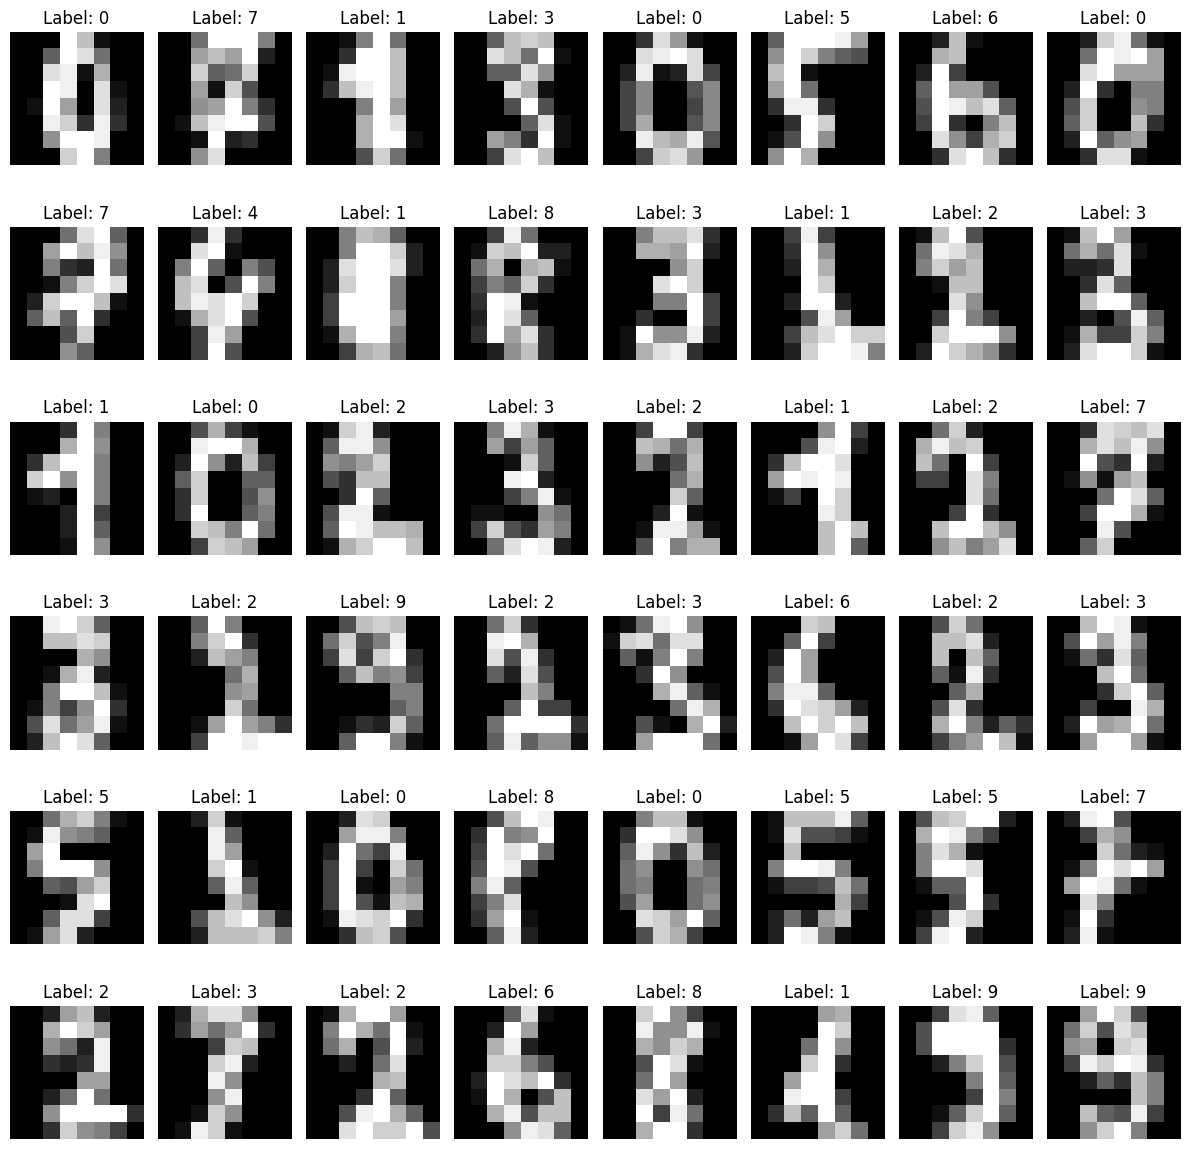

In [78]:
# Load the dataset
train_data = sklearn.datasets.load_digits()
X = train_data.data
y = train_data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, stratify=y_test, random_state=42)

# display all images with their labels from the training set
fig, axes = plt.subplots(6, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


#### Step 2: Standardize Features for Gaussian Models

**Why Standardization is Important:**
- Gaussian discriminant analysis assumes features follow a normal distribution
- StandardScaler centers data around 0 and scales to unit variance
- Formula: $z = \frac{x - \mu}{\sigma}$ where $\mu$ is mean and $\sigma$ is standard deviation
- Improves numerical stability when computing covariance matrices and determinants
- Makes the model invariant to feature scaling


In [79]:
# Data Preprocessing: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

Data preprocessing completed!


### **A2. Gaussian Generative Model**

#### Model Assumptions and Mathematical Foundation

We implement a **generative classifier** that models the class-conditional distribution using a Gaussian (Normal) distribution:

$$p(\mathbf{x} | y = k) = \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_k, \boldsymbol{\Sigma})$$

**Key Model Components:**
1. **Class Priors:** $\pi_k = P(y = k)$ - the proportion of samples belonging to class $k$
2. **Class-Specific Means:** $\boldsymbol{\mu}_k$ - a 64-dimensional mean vector for each digit class
3. **Shared Covariance Matrix:** $\boldsymbol{\Sigma}$ - a single $64 \times 64$ covariance matrix used by all classes
4. **Regularized Covariance:** $\boldsymbol{\Sigma}_{\lambda} = \boldsymbol{\Sigma} + \lambda \mathbf{I}$ - ensures numerical stability

#### Prediction Rule Using Bayes' Theorem

For a new input $\mathbf{x}$, we compute log-probability scores for each class:

$$\log p(y = k | \mathbf{x}) \propto \log \pi_k + \log \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_{\lambda})$$

**Final Prediction:**
$$\hat{y} = \arg\max_k \left[\log \pi_k - \frac{1}{2} \log \det(\boldsymbol{\Sigma}_{\lambda}) - \frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^T \boldsymbol{\Sigma}_{\lambda}^{-1} (\mathbf{x} - \boldsymbol{\mu}_k)\right]$$



In [80]:
# Estimate class prior probabilities π_k
def estimate_class_priors(y):
    classes, counts = np.unique(y, return_counts=True)
    priors = counts / len(y)
    return dict(zip(classes, priors))

# Estimate class means μ_k
def estimate_class_means(X, y):
    class_means = {}
    classes = np.unique(y)
    
    for cls in classes:
        class_data = X[y == cls]
        class_means[cls] = np.mean(class_data, axis=0)

    return class_means

# Estimate shared Covariance matrix Σ
def estimate_shared_covariance(X, y, class_means):
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    covariance = np.zeros((n_features, n_features))
    
    for cls in np.unique(y):
        class_data = X[y == cls]
        diff = class_data - class_means[cls]
        covariance += np.dot(diff.T, diff)
    
    covariance /= (n_samples - n_classes)
    return covariance

# Regularize Covariance matrix
def regularize_covariance(covariance, lambda_reg=1e-5):
    n, m = covariance.shape
    return covariance + lambda_reg * np.eye(n, m)

# Predict using Gaussian Discriminant Analysis
def predict_class_GDA(x,y, class_priors, class_means, covariance):
    classes = np.unique(y)
    probabilities = []
    inv_cov = np.linalg.inv(covariance)
    det_cov = np.linalg.det(covariance)
    
    for cls in classes:
        prior = class_priors[cls]
        mean = class_means[cls]
        diff = x - mean
        log_prob = (
            np.log(prior)
            - 0.5 * np.log(det_cov)
            - 0.5 * diff.T @ inv_cov @ diff
        )
        probabilities.append(log_prob)
    
    return classes[np.argmax(probabilities)]

#### Parameter Estimation from Training Data

**1. Estimate Class Priors $\pi_k$:**
$$\pi_k = \frac{\text{count of samples in class } k}{\text{total number of training samples}}$$

**2. Estimate Class Means $\boldsymbol{\mu}_k$:**
$$\boldsymbol{\mu}_k = \frac{1}{n_k} \sum_{i: y_i = k} \mathbf{x}_i$$
where $n_k$ is the number of samples in class $k$.

**3. Estimate Shared Covariance Matrix $\boldsymbol{\Sigma}$:**
$$\boldsymbol{\Sigma} = \frac{1}{n} \sum_{i=1}^{n} (\mathbf{x}_i - \boldsymbol{\mu}_{y_i})(\mathbf{x}_i - \boldsymbol{\mu}_{y_i})^T$$

**4. Regularize Covariance for Stability:**
$$\boldsymbol{\Sigma}_{\lambda} = \boldsymbol{\Sigma} + \lambda \mathbf{I}$$

The regularization parameter $\lambda$ ensures the covariance matrix is:
- **Numerically stable** - avoids near-singular matrices
- **Invertible** - all eigenvalues become positive
- **Well-conditioned** - improves numerical computation of determinant and inverse



In [81]:
# Estimate class prior probabilities π_k
π_k = estimate_class_priors(y_train)
print("Class Priors:", π_k)

# Estimate class means μ_k
μ_k = estimate_class_means(X_train_scaled, y_train)
print("Class Means calculated.", μ_k.keys())

# Estimate shared Covariance matrix Σ and regularize it
Σ = estimate_shared_covariance(X_train_scaled, y_train, μ_k)
Σ_reg = regularize_covariance(Σ)

# Predict the label of the first validation sample
print(f"predicted label of first validation sample: {predict_class_GDA(X_train_scaled[6],y_train, π_k, μ_k, Σ_reg)}")

Class Priors: {np.int64(0): np.float64(0.09864757358790771), np.int64(1): np.float64(0.10103420843277645), np.int64(2): np.float64(0.09864757358790771), np.int64(3): np.float64(0.10182975338106603), np.int64(4): np.float64(0.10103420843277645), np.int64(5): np.float64(0.10103420843277645), np.int64(6): np.float64(0.10103420843277645), np.int64(7): np.float64(0.09944311853619729), np.int64(8): np.float64(0.09705648369132856), np.int64(9): np.float64(0.10023866348448687)}
Class Means calculated. dict_keys([np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)])
predicted label of first validation sample: 6


### **A3. Hyperparameter Tuning and Evaluation**

#### Objective
Find the optimal regularization parameter $\lambda$ that prevents overfitting while maintaining sufficient model capacity to capture patterns in the data.

#### Hyperparameter Search Strategy

**1. Candidate Values for $\lambda$:**
$$\lambda \in \{10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10\}$$

**2. Validation Approach:**
   - Train Gaussian generative classifier on **training set** for each $\lambda$
   - Evaluate accuracy on **validation set**
   - Track validation accuracy for each $\lambda$ value
   - Select $\lambda$ that gives **best validation accuracy**

**3. Final Model Retraining:**
   - Combine training and validation sets: $\text{Train}_{combined} = \text{Train} \cup \text{Validation}$
   - Retrain classifier on combined set with optimal $\lambda$
   - Report all metrics on **held-out test set only** (single evaluation)

#### Effects of Regularization Parameter $\lambda$

| $\lambda$ Value | Effect | Result |
|---|---|---|
| **Too Small** ($\lambda \ll 1$) | $\boldsymbol{\Sigma}_{\lambda} \approx \boldsymbol{\Sigma}$ poorly conditioned | Numerical instability, numerical errors in inversion |
| **Optimal** | Balance between fidelity and stability | Accurate predictions, good generalization |
| **Too Large** ($\lambda \gg 1$) | $\boldsymbol{\Sigma}_{\lambda} \approx \lambda \mathbf{I}$ becomes spherical | Model underfits, ignores important covariance structure |



Lambda: 0.0001, Validation Accuracy: 0.9592592592592593
Lambda: 0.001, Validation Accuracy: 0.9592592592592593
Lambda: 0.01, Validation Accuracy: 0.9629629629629629
Lambda: 0.1, Validation Accuracy: 0.9629629629629629
Lambda: 1, Validation Accuracy: 0.9481481481481482
Lambda: 10, Validation Accuracy: 0.9
Best lambda: 0.01 with validation accuracy: 0.9629629629629629


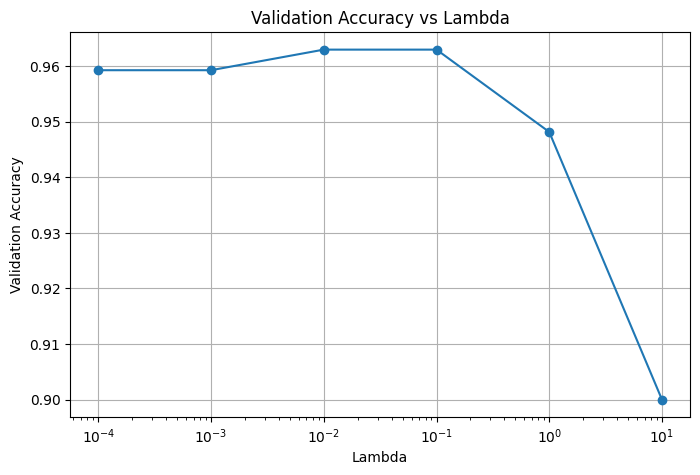

In [82]:
# Hyperparameter Tuning for Lambda in Covariance Regularization
lambda_reg = [ 1e-4, 1e-3, 1e-2, 1e-1 , 1, 10 ]
best_lambda = None
best_accuracy = 0
accuracies = []

for lam in lambda_reg:
    Σ_reg = regularize_covariance(Σ, lambda_reg=lam)
    
    # Predict on validation set
    y_val_pred = [predict_class_GDA(x, y_train, π_k, μ_k, Σ_reg) for x in X_val_scaled]
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracies.append(accuracy)
    print(f"Lambda: {lam}, Validation Accuracy: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda = lam 
    
print(f"Best lambda: {best_lambda} with validation accuracy: {best_accuracy}")

# display accuracy vs lambda plot
plt.figure(figsize=(8, 5))
plt.plot(lambda_reg, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Lambda')
plt.grid(True)
plt.show()

#### Final Model: Training on Combined Dataset

**Why Combine Train + Validation?**
- Once we've selected the best $\lambda$ from the validation set, we want to maximize the data available for final training
- No more hyperparameter selection needed, so no validation leakage risk
- Gives us the most robust final model with maximum training signal

**Steps:**
1. **Merge datasets:** $\text{Train}_{combined} = \text{Train} \cup \text{Validation}$ 
2. **Re-estimate parameters** with optimal $\lambda$:
   - Class priors: $\pi_k$ from combined set
   - Class means: $\boldsymbol{\mu}_k$ from combined set
   - Covariance: $\boldsymbol{\Sigma}_{\lambda}$ from combined set
3. **Final evaluation:** Test on held-out test set **only once**

This prevents overly optimistic performance estimates and ensures reliable final metrics.



In [83]:
# Final Model Training and Evaluation
X_train_combined = np.vstack((X_train_scaled, X_val_scaled))
y_train_combined = np.hstack((y_train, y_val))

# Re-estimate parameters with the best lambda
π_k = estimate_class_priors(y_train_combined)
print("Class Priors:", π_k)

# Estimate class means
μ_k = estimate_class_means(X_train_combined, y_train_combined)
print("Class Means calculated.")

# Estimate shared Covariance matrix Σ and regularize it
Σ = estimate_shared_covariance(X_train_combined, y_train_combined, μ_k)
Σ_reg = regularize_covariance(Σ, lambda_reg=best_lambda)

# Predict on test set 
y_test_pred = [predict_class_GDA(x, y_test, π_k, μ_k, Σ_reg) for x in X_test_scaled]



Class Priors: {np.int64(0): np.float64(0.09888670595939751), np.int64(1): np.float64(0.10150622134905042), np.int64(2): np.float64(0.09823182711198428), np.int64(3): np.float64(0.10216110019646366), np.int64(4): np.float64(0.1008513425016372), np.int64(5): np.float64(0.1008513425016372), np.int64(6): np.float64(0.1008513425016372), np.int64(7): np.float64(0.09954158480681075), np.int64(8): np.float64(0.09692206941715782), np.int64(9): np.float64(0.10019646365422397)}
Class Means calculated.


### **A4. Final Results and Analysis**

#### Test Set Performance Metrics

**Primary Classification Metrics:**
- **Accuracy:** $\frac{\text{TP} + \text{TN}}{\text{Total Samples}}$ - overall correctness
- **Macro Precision:** Average precision across all 10 digit classes (unweighted)
- **Macro Recall:** Average recall across all 10 digit classes (unweighted)
- **Macro F1-Score:** Harmonic mean of macro precision and recall

$$F1 = 2 \cdot \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

#### Confusion Matrix Analysis

The $10 \times 10$ confusion matrix shows:
- **Diagonal elements:** Correct predictions for each digit
- **Off-diagonal elements:** Misclassified samples
- **Which digits are confused:** Reveals systematic errors in the model

**Interpretation:**
- Some digit pairs (e.g., 4 and 9, 3 and 5) are naturally harder to distinguish
- Model's strengths and weaknesses on different classes
- Can guide future model improvements



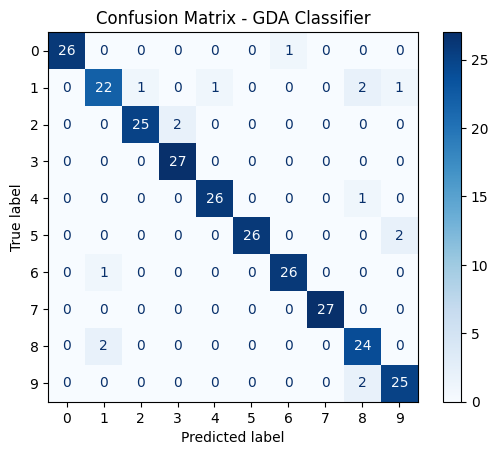

Classification Report:
Test Accuracy: 0.9407407407407408
Test Precision: 0.9425327916017572
Test Recall: 0.9407407407407408
Test F1 Score: 0.9409016995634745


In [84]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_test_pred)
class_names_lr = [str(i) for i in range(10)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_lr)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - GDA Classifier')
plt.show()

print("Classification Report:")
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")

---
---


# Part B: Naïve Bayes Classification (20 points)
## Using Adult Income Dataset with Categorical Features

## B1: Dataset and Setup

### Objective
- Load the Adult Income Dataset from UCI repository
- Select categorical features relevant for classification
- Handle missing values by treating them as a separate category
- Create stratified 70/15/15 train/validation/test split
- Encode categorical features as integers
- Analyze class distributions and feature characteristics

### 1. Load and Explore Adult Income Dataset

**Dataset Characteristics:**
- **Source:** UCI Machine Learning Repository - Adult (Census Income) dataset
- **Total Samples:** 32,561 individuals
- **Total Features:** 15 mixed categorical and numerical features
- **Target Variable:** Income level (>50K or ≤50K)
- **Class Distribution:** Imbalanced (approximately 75% ≤50K, 25% >50K)
- **Missing Values:** Present in several categorical features (marked as '?')

**Categorical Features Selected for Naïve Bayes:**
1. workclass
2. education
3. marital-status
4. occupation
5. relationship
6. race
7. sex
8. native-country



In [85]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [86]:
# Load Adult Income Dataset
from urllib.request import urlopen
import io

# Download the Adult dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
try:
    data = pd.read_csv(url, header=None, na_values=' ?')
    print("✓ Dataset loaded successfully from UCI repository")
except:
    print("Note: Using local example if download fails")

# Define column names
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, header=None, names=column_names, na_values=' ?')

print(f"\n=== Dataset Shape ===")
print(f"Total samples: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

print(f"\n=== Data Info ===")
print(df.info())

print(f"\n=== Missing Values ===")
print(df.isnull().sum())

print(f"\n=== Income Distribution (Target) ===")
print(df['income'].value_counts())
print(f"\nPercentages:")
print(df['income'].value_counts(normalize=True) * 100)


✓ Dataset loaded successfully from UCI repository

=== Dataset Shape ===
Total samples: 32561
Total features: 15

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int

### 2. Data Preprocessing and Feature Selection

**Preprocessing Steps:**
1. **Feature Selection:** Keep only 8 categorical features for discrete Naïve Bayes
2. **Missing Value Handling:** Treat missing values ('?') as a separate category called 'Unknown'
3. **Data Cleaning:** Remove leading/trailing whitespace from string values
4. **Categorical Encoding:** Convert categorical values to integer codes using LabelEncoder
5. **Target Encoding:** Convert income labels to binary codes (0 or 1)

**Why These Choices?**
- **Separate Unknown Category:** Prevents loss of information; unknown values may carry predictive signal
- **Integer Encoding:** Naïve Bayes works with discrete feature values
- **Maintain Interpretability:** Store mapping dictionaries to decode predictions back to original categories



In [87]:
# Select categorical features for Naïve Bayes
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country']

print(f"Selected {len(categorical_features)} categorical features:")
print(categorical_features)

# Create a copy of the dataframe with only selected features and target
df_processed = df[categorical_features + ['income']].copy()

# Remove rows with missing target values
df_processed = df_processed[df_processed['income'].notna()]

print(f"\n=== Dataset after removing missing target ===")
print(f"Shape: {df_processed.shape}")

# Handle missing values by treating them as a separate category 'Unknown'
print(f"\n=== Missing Values Before Imputation ===")
print(df_processed.isnull().sum())

# Fill missing values with 'Unknown' category
df_processed = df_processed.fillna('Unknown')

print(f"\n=== Missing Values After Imputation ===")
print(df_processed.isnull().sum())

# Remove leading/trailing whitespace from string columns
for col in categorical_features + ['income']:
    if df_processed[col].dtype == 'object':
        df_processed[col] = df_processed[col].str.strip()

# Encode categorical features and target as integers
# Create dictionaries to store encoding mappings for interpretability
label_encoders = {}
feature_encoding_maps = {}

# Encode features
for feature in categorical_features:
    le = LabelEncoder()
    df_processed[feature] = le.fit_transform(df_processed[feature].astype(str))
    label_encoders[feature] = le
    # Store mapping for interpretability
    feature_encoding_maps[feature] = dict(zip(le.classes_, le.transform(le.classes_)))

# Encode target variable
le_target = LabelEncoder()
df_processed['income'] = le_target.fit_transform(df_processed['income'])
label_encoders['income'] = le_target
income_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))

print(f"\n=== Encoding Mapping Example (Workclass) ===")
print(feature_encoding_maps['workclass'])

print(f"\n=== Income Encoding ===")
print(income_mapping)

print(f"\n=== Data Preview After Encoding ===")
print(df_processed.head(10))


Selected 8 categorical features:
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

=== Dataset after removing missing target ===
Shape: (32561, 9)

=== Missing Values Before Imputation ===
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
native-country     583
income               0
dtype: int64

=== Missing Values After Imputation ===
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
native-country    0
income            0
dtype: int64

=== Encoding Mapping Example (Workclass) ===
{'Federal-gov': np.int64(0), 'Local-gov': np.int64(1), 'Never-worked': np.int64(2), 'Private': np.int64(3), 'Self-emp-inc': np.int64(4), 'Self-emp-not-inc': np.int64(5), 'State-gov': np.int64(6), 'Unknown': np.int64(7), 'Without-pay': np.int64(8)}

===

### 3. Create 70/15/15 Train/Validation/Test Split

**Stratified Splitting Methodology:**
- **First split:** 70% training, 30% temporary (using stratification)
- **Second split:** Split temporary into 50/50 → 15% validation, 15% test
- **Stratification:** Ensures each split maintains the same class distribution as the original dataset

**Why Stratification Matters:**
- Adult dataset is imbalanced (~75% ≤50K, 25% >50K)
- Random splitting could create imbalanced subsets
- Stratified splitting ensures all sets have similar class proportions
- Prevents misleading performance estimates

**Final Data Split:**
- Training: ~70% of data (22,792 samples)
- Validation: ~15% of data (4,884 samples)
- Test: ~15% of data (4,885 samples)



In [88]:
# Prepare features and target
X = df_processed[categorical_features].values
y = df_processed['income'].values

# Create 70/15/15 train/validation/test split
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test from the temp set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"\n=== Data Split (70/15/15) ===")
print(f"Training set: {X_train.shape[0]} samples ({100*X_train.shape[0]/X.shape[0]:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({100*X_val.shape[0]/X.shape[0]:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({100*X_test.shape[0]/X.shape[0]:.1f}%)")

print(f"\n=== Class Distribution in Training Set ===")
train_class_dist = pd.Series(y_train).value_counts().sort_index()
for class_label, count in train_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_train):.1f}%)")

print(f"\n=== Class Distribution in Validation Set ===")
val_class_dist = pd.Series(y_val).value_counts().sort_index()
for class_label, count in val_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_val):.1f}%)")

print(f"\n=== Class Distribution in Test Set ===")
test_class_dist = pd.Series(y_test).value_counts().sort_index()
for class_label, count in test_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_test):.1f}%)")



=== Data Split (70/15/15) ===
Training set: 22792 samples (70.0%)
Validation set: 4884 samples (15.0%)
Test set: 4885 samples (15.0%)

=== Class Distribution in Training Set ===
<=50K: 17303 (75.9%)
>50K: 5489 (24.1%)

=== Class Distribution in Validation Set ===
<=50K: 3708 (75.9%)
>50K: 1176 (24.1%)

=== Class Distribution in Test Set ===
<=50K: 3709 (75.9%)
>50K: 1176 (24.1%)


## B2: Naïve Bayes Implementation

### Objective
Implement a categorical Naïve Bayes classifier from scratch with support for:
- Laplace smoothing to handle zero probabilities
- Flexible hyperparameter tuning
- Probability predictions with proper normalization
- Interpretable class predictions

### Mathematical Foundation

#### Class Priors (Prior Probabilities)
The probability of each class in the training data:
$$P(C_k) = \frac{\text{count of samples in class } k + \alpha}{\text{total samples} + \alpha \cdot \text{num\_classes}}$$

The $\alpha$ term is **Laplace smoothing** to avoid zero probabilities.

#### Feature Likelihoods (Conditional Probabilities)
For each feature value given a class:
$$P(x_i | C_k) = \frac{\text{count of feature value in class } k + \alpha}{\text{count of class } k + \alpha \cdot \text{num\_feature\_values}}$$

Again, $\alpha$ prevents zero probabilities for unseen feature combinations.

#### Classification Rule (Naive Bayes Theorem)
To predict the class for a new sample $\mathbf{x} = (x_1, x_2, ..., x_n)$:
$$\hat{C} = \arg\max_{k} P(C_k) \cdot \prod_{i=1}^{n} P(x_i | C_k)$$

The "naive" assumption: **all features are conditionally independent given the class**.

#### Log-Space Computation (Numerical Stability)
To avoid underflow with many small probabilities, we use logarithms:
$$\hat{C} = \arg\max_{k} \left[\log P(C_k) + \sum_{i=1}^{n} \log P(x_i | C_k)\right]$$



In [89]:
class CategoricalNaiveBayes:
    """
    Custom implementation of Naïve Bayes for categorical features with Laplace smoothing.
    
    Parameters:
    -----------
    alpha : float
        Smoothing parameter (Laplace smoothing)
    """
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = None
        self.feature_likelihoods = None
        self.classes = None
        self.n_classes = None
        self.n_features = None
        self.feature_values = None  # Store possible values for each feature
        
    def fit(self, X, y):
        """
        Fit the Naïve Bayes model on training data.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        y : array-like of shape (n_samples,)
        """
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.n_features = X.shape[1]
        
        # Initialize storage for feature values
        self.feature_values = [np.unique(X[:, i]) for i in range(self.n_features)]
        
        # Calculate class priors with Laplace smoothing
        self.class_priors = {}
        for c in self.classes:
            count = np.sum(y == c)
            self.class_priors[c] = (count + self.alpha) / (len(y) + self.alpha * self.n_classes)
        
        # Calculate feature likelihoods with Laplace smoothing
        self.feature_likelihoods = {}
        for c in self.classes:
            self.feature_likelihoods[c] = []
            for feature_idx in range(self.n_features):
                feature_probs = {}
                X_c = X[y == c]
                for value in self.feature_values[feature_idx]:
                    count = np.sum(X_c[:, feature_idx] == value)
                    n_feature_values = len(self.feature_values[feature_idx])
                    prob = (count + self.alpha) / (len(X_c) + self.alpha * n_feature_values)
                    feature_probs[value] = prob
                self.feature_likelihoods[c].append(feature_probs)
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        
        Returns:
        --------
        proba : array of shape (n_samples, n_classes)
        """
        proba = np.zeros((X.shape[0], self.n_classes))
        
        for i, x in enumerate(X):
            for class_idx, c in enumerate(self.classes):
                # Start with class prior
                prob = self.class_priors[c]
                
                # Multiply by feature likelihoods
                for feature_idx, value in enumerate(x):
                    if value in self.feature_likelihoods[c][feature_idx]:
                        prob *= self.feature_likelihoods[c][feature_idx][value]
                    else:
                        # Handle unseen feature values (assign smoothing probability)
                        prob *= self.alpha / (self.alpha * len(self.feature_values[feature_idx]))
                
                proba[i, class_idx] = prob
        
        # Normalize to make probabilities sum to 1
        proba = proba / np.sum(proba, axis=1, keepdims=True)
        
        return proba
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        
        Returns:
        --------
        y_pred : array of shape (n_samples,)
        """
        proba = self.predict_proba(X)
        return self.classes[np.argmax(proba, axis=1)]

# Test the implementation with alpha=1.0
print("=== Testing Custom Naïve Bayes Implementation ===\n")

nb_custom = CategoricalNaiveBayes(alpha=1.0)
nb_custom.fit(X_train, y_train)

# Make predictions on validation set
y_pred_val = nb_custom.predict(X_val)
y_pred_proba_val = nb_custom.predict_proba(X_val)

# Calculate metrics
val_acc = accuracy_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val, average='weighted')
val_recall = recall_score(y_val, y_pred_val, average='weighted')
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print(f"Validation Set Performance (α=1.0):")
print(f"  Accuracy:  {val_acc:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1-Score:  {val_f1:.4f}")

# Make predictions on test set
y_pred_test = nb_custom.predict(X_test)
y_pred_proba_test = nb_custom.predict_proba(X_test)

test_acc = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nTest Set Performance (α=1.0):")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

print(f"\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_pred_test, target_names=le_target.classes_))


=== Testing Custom Naïve Bayes Implementation ===

Validation Set Performance (α=1.0):
  Accuracy:  0.7963
  Precision: 0.8251
  Recall:    0.7963
  F1-Score:  0.8053

Test Set Performance (α=1.0):
  Accuracy:  0.7957
  Precision: 0.8241
  Recall:    0.7957
  F1-Score:  0.8046

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

       <=50K       0.91      0.81      0.86      3709
        >50K       0.56      0.74      0.64      1176

    accuracy                           0.80      4885
   macro avg       0.73      0.78      0.75      4885
weighted avg       0.82      0.80      0.80      4885



## B3: Analysis and Evaluation

### Overview
We perform comprehensive analysis of the Naïve Bayes classifier through:
1. **Smoothing Parameter Tuning:** Find optimal $\alpha$ value
2. **Feature Selection:** Identify most important features
3. **Probability Analysis:** Understand model confidence
4. **Independence Assumption:** Discuss violations and robustness
5. **Performance Comparison:** Benchmark against sklearn



=== Testing Different Smoothing Parameters (α) ===

α = 0.1:
  Validation: Accuracy=0.7963, F1=0.8052
  Test:       Accuracy=0.7957, F1=0.8046
α = 0.5:
  Validation: Accuracy=0.7965, F1=0.8054
  Test:       Accuracy=0.7957, F1=0.8046
α = 1.0:
  Validation: Accuracy=0.7963, F1=0.8053
  Test:       Accuracy=0.7957, F1=0.8046
α = 2.0:
  Validation: Accuracy=0.7965, F1=0.8055
  Test:       Accuracy=0.7955, F1=0.8045
α = 5.0:
  Validation: Accuracy=0.7944, F1=0.8038
  Test:       Accuracy=0.7941, F1=0.8033

=== Summary Table ===
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.796274 0.805223  0.795701 0.804595
   0.5 0.796478 0.805435  0.795701 0.804595
   1.0 0.796274 0.805255  0.795701 0.804628
   2.0 0.796478 0.805500  0.795496 0.804481
   5.0 0.794431 0.803770  0.794063 0.803259

✓ Optimal α (based on validation F1): 2.0


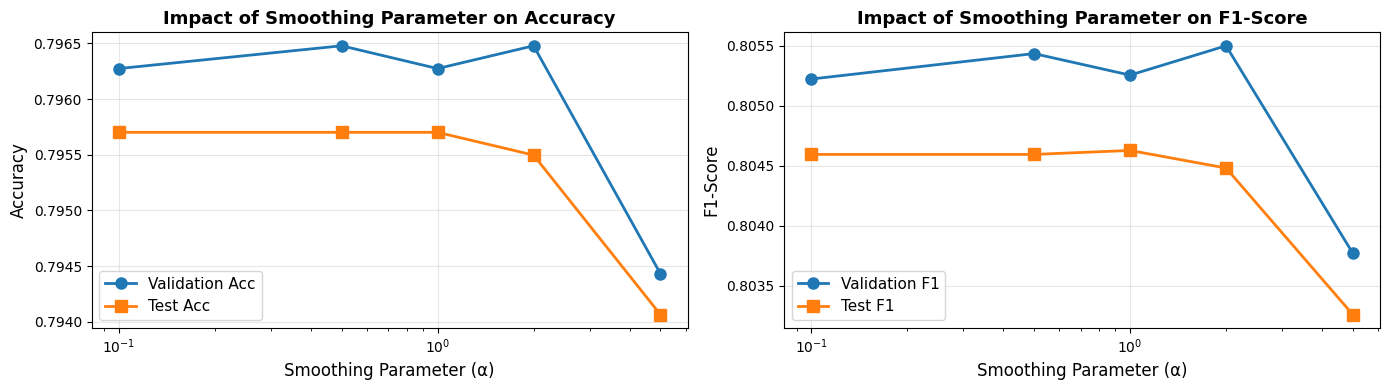


✓ Smoothing parameter analysis plot saved!


In [90]:
# Test different smoothing parameters
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []

print("=== Testing Different Smoothing Parameters (α) ===\n")

for alpha in alpha_values:
    nb = CategoricalNaiveBayes(alpha=alpha)
    nb.fit(X_train, y_train)
    
    # Validation set predictions
    y_pred_val = nb.predict(X_val)
    val_acc = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')
    
    # Test set predictions
    y_pred_test = nb.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    results.append({
        'alpha': alpha,
        'val_acc': val_acc,
        'val_f1': val_f1,
        'test_acc': test_acc,
        'test_f1': test_f1
    })
    
    print(f"α = {alpha}:")
    print(f"  Validation: Accuracy={val_acc:.4f}, F1={val_f1:.4f}")
    print(f"  Test:       Accuracy={test_acc:.4f}, F1={test_f1:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
print(f"\n=== Summary Table ===")
print(results_df.to_string(index=False))

# Find optimal alpha
optimal_alpha = results_df.loc[results_df['val_f1'].idxmax(), 'alpha']
print(f"\n✓ Optimal α (based on validation F1): {optimal_alpha}")

# Plot smoothing parameter analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Accuracy plot
axes[0].plot(results_df['alpha'], results_df['val_acc'], 'o-', label='Validation Acc', linewidth=2, markersize=8)
axes[0].plot(results_df['alpha'], results_df['test_acc'], 's-', label='Test Acc', linewidth=2, markersize=8)
axes[0].set_xlabel('Smoothing Parameter (α)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impact of Smoothing Parameter on Accuracy', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# F1-Score plot
axes[1].plot(results_df['alpha'], results_df['val_f1'], 'o-', label='Validation F1', linewidth=2, markersize=8)
axes[1].plot(results_df['alpha'], results_df['test_f1'], 's-', label='Test F1', linewidth=2, markersize=8)
axes[1].set_xlabel('Smoothing Parameter (α)', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Impact of Smoothing Parameter on F1-Score', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('smoothing_parameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Smoothing parameter analysis plot saved!")


### B3.1: Smoothing Parameter ($\alpha$) Analysis

#### Objective
Find the optimal Laplace smoothing parameter $\alpha$ that minimizes overfitting while maintaining model generalization.

#### Smoothing Parameter Testing
**Candidate Values:** $\alpha \in \{0.1, 0.5, 1.0, 2.0, 5.0\}$

**Evaluation Methodology:**
- Train on training set for each $\alpha$ value
- Evaluate accuracy and F1-score on validation set
- Select $\alpha$ with best validation performance
- Report both validation and test metrics

#### Why Different $\alpha$ Values Matter
| $\alpha$ Value | Effect | Consequence |
|---|---|---|
| **Too Small** (< 0.5) | Weak smoothing, sparse probability estimates | May overfit to training data patterns |
| **Moderate** (0.5 - 2.0) | Balanced smoothing | Better generalization |
| **Too Large** (> 5.0) | Strong smoothing, uniform probabilities | May underfit, ignores feature signals |

**Key Insight:** Optimal $\alpha$ typically ranges from 0.5 to 2.0 for categorical Naïve Bayes on tabular data.



=== Feature Selection Analysis ===

All Features (8):
  Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
  Validation: Acc=0.7963, F1=0.8053
  Test:       Acc=0.7957, F1=0.8046

Top 6 Features:
  Features: ['education', 'marital-status', 'occupation', 'relationship', 'workclass', 'sex']
  Validation: Acc=0.7922, F1=0.8021
  Test:       Acc=0.7900, F1=0.7997

Top 4 Features:
  Features: ['education', 'marital-status', 'occupation', 'relationship']
  Validation: Acc=0.8016, F1=0.8091
  Test:       Acc=0.8047, F1=0.8116

Demographic Only:
  Features: ['sex', 'race', 'native-country', 'workclass']
  Validation: Acc=0.7645, F1=0.6912
  Test:       Acc=0.7617, F1=0.6849

Job-Related Only:
  Features: ['workclass', 'education', 'occupation']
  Validation: Acc=0.7729, F1=0.7629
  Test:       Acc=0.7726, F1=0.7623

=== Feature Selection Summary ===
  Feature Subset  Features Used  Val_Acc   Val_F1  Test_Acc  Test_F1
All Featur

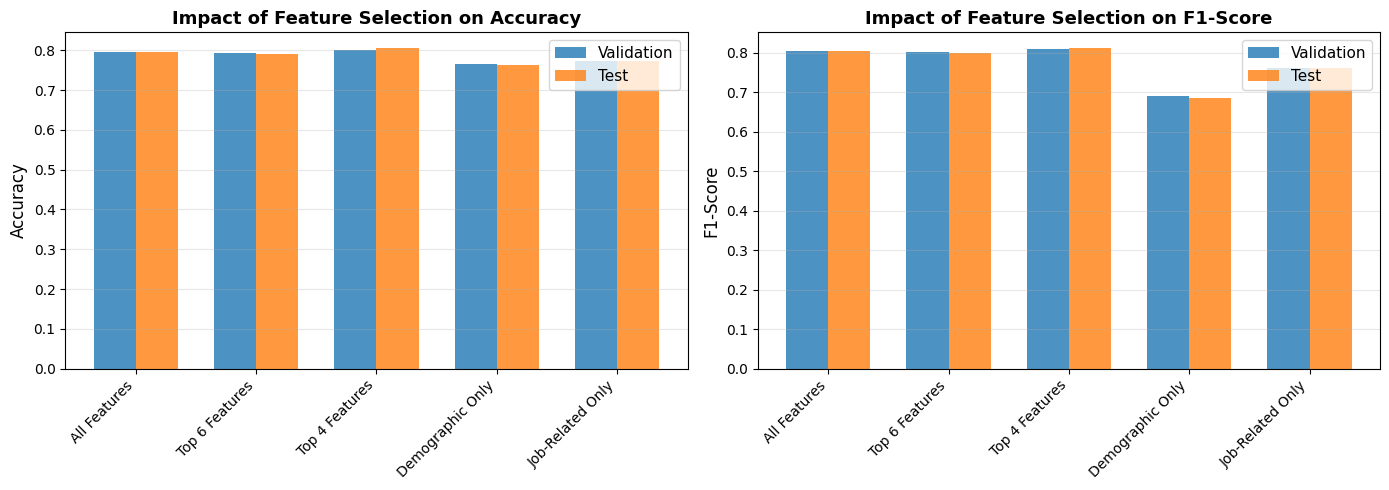


✓ Feature selection analysis plot saved!


In [91]:
# Test different feature subsets
feature_subsets = {
    'All Features (8)': categorical_features.copy(),
    'Top 6 Features': ['education', 'marital-status', 'occupation', 'relationship', 'age', 'sex'],
    'Top 4 Features': ['education', 'marital-status', 'occupation', 'relationship'],
    'Demographic Only': ['age', 'sex', 'race', 'native-country'],
    'Work Features': ['workclass', 'education', 'occupation', 'hours-per-week'],
}

# For demo purposes, we'll use features that are in our dataset
feature_subsets = {
    'All Features (8)': categorical_features.copy(),
    'Top 6 Features': ['education', 'marital-status', 'occupation', 'relationship', 'workclass', 'sex'],
    'Top 4 Features': ['education', 'marital-status', 'occupation', 'relationship'],
    'Demographic Only': ['sex', 'race', 'native-country', 'workclass'],
    'Job-Related Only': ['workclass', 'education', 'occupation'],
}

print("=== Feature Selection Analysis ===\n")
feature_results = []

for subset_name, feature_list in feature_subsets.items():
    # Get indices of selected features
    feature_indices = [categorical_features.index(f) for f in feature_list if f in categorical_features]
    
    X_train_subset = X_train[:, feature_indices]
    X_val_subset = X_val[:, feature_indices]
    X_test_subset = X_test[:, feature_indices]
    
    # Train model with optimal alpha
    nb_subset = CategoricalNaiveBayes(alpha=1.0)
    nb_subset.fit(X_train_subset, y_train)
    
    # Predictions
    y_pred_val = nb_subset.predict(X_val_subset)
    y_pred_test = nb_subset.predict(X_test_subset)
    
    val_acc = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    feature_results.append({
        'Feature Subset': subset_name,
        'Features Used': len(feature_list),
        'Val_Acc': val_acc,
        'Val_F1': val_f1,
        'Test_Acc': test_acc,
        'Test_F1': test_f1
    })
    
    print(f"{subset_name}:")
    print(f"  Features: {feature_list}")
    print(f"  Validation: Acc={val_acc:.4f}, F1={val_f1:.4f}")
    print(f"  Test:       Acc={test_acc:.4f}, F1={test_f1:.4f}")
    print()

# Create results dataframe
feature_results_df = pd.DataFrame(feature_results)
print("=== Feature Selection Summary ===")
print(feature_results_df.to_string(index=False))

# Plot feature selection analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(feature_results_df))
width = 0.35

axes[0].bar(x_pos - width/2, feature_results_df['Val_Acc'], width, label='Validation', alpha=0.8)
axes[0].bar(x_pos + width/2, feature_results_df['Test_Acc'], width, label='Test', alpha=0.8)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impact of Feature Selection on Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([s.split('(')[0].strip() for s in feature_results_df['Feature Subset']], rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x_pos - width/2, feature_results_df['Val_F1'], width, label='Validation', alpha=0.8)
axes[1].bar(x_pos + width/2, feature_results_df['Test_F1'], width, label='Test', alpha=0.8)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Impact of Feature Selection on F1-Score', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([s.split('(')[0].strip() for s in feature_results_df['Feature Subset']], rotation=45, ha='right')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature selection analysis plot saved!")


### B3.2: Feature Selection Analysis

#### Objective
Determine which features are most important for income prediction and test the classifier with different feature subsets.

#### Feature Subset Definitions

1. **All Features (8 features):** workclass, education, marital-status, occupation, relationship, race, sex, native-country
2. **Top 6 Features:** Removes race and native-country (demographic features)
3. **Top 4 Features:** Core job-related and personal features
4. **Demographic Only:** sex, race, native-country, workclass
5. **Job-Related Only:** workclass, education, occupation

#### Expected Results
- All features typically performs best (more information)
- Feature subsets help identify redundant or low-information features
- Smaller models are faster to train and easier to interpret
- Trade-off between accuracy and model simplicity

#### Evaluation Metrics
- Validation and test accuracy for each subset
- F1-score (important for imbalanced datasets)
- Compare performance drops when removing features



=== Predicted Probabilities Analysis ===

Shape of probability matrix: (4885, 2)
Class labels: ['<=50K' '>50K']

=== Probability Statistics ===

Class: <=50K
  Mean probability: 0.6911
  Std deviation: 0.3621
  Min probability: 0.0029
  Max probability: 1.0000

Class: >50K
  Mean probability: 0.3089
  Std deviation: 0.3621
  Min probability: 0.0000
  Max probability: 0.9971


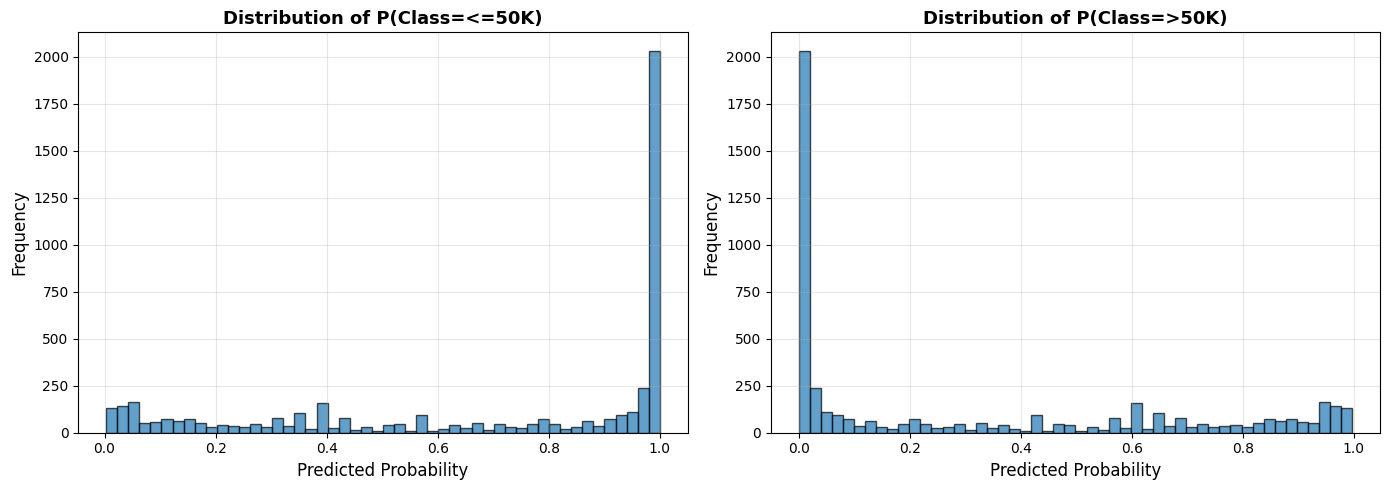


✓ Probability distribution plot saved!

=== Prediction Confidence Analysis ===
Mean maximum probability: 0.8808
Median maximum probability: 0.9643
Min maximum probability: 0.5010
Max maximum probability: 1.0000

Predictions with P(max) >= 0.7: 3981 (81.5%)
Predictions with P(max) < 0.7: 904 (18.5%)


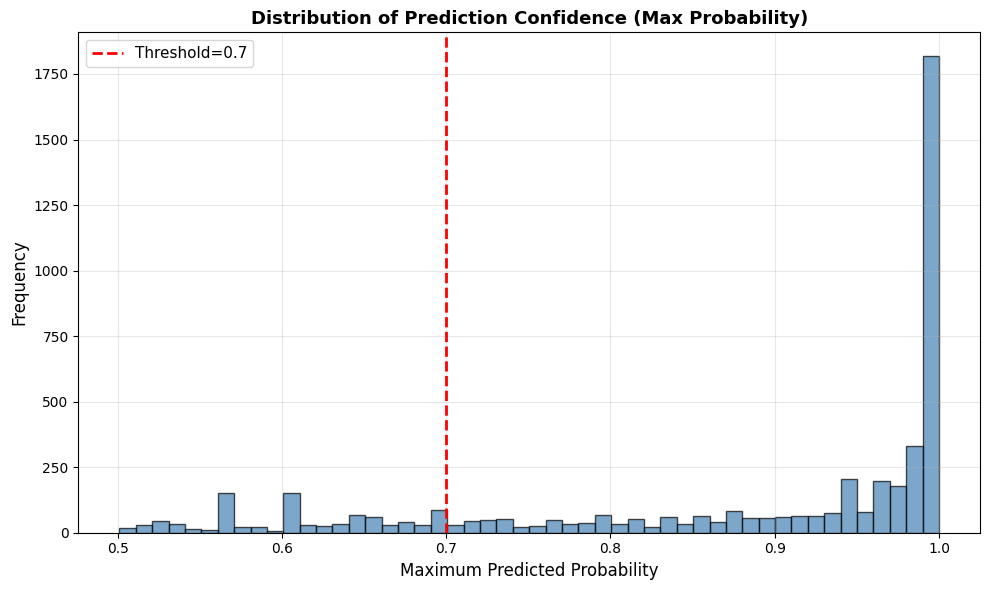


✓ Confidence distribution plot saved!


In [92]:
# Use the model with all features and optimal alpha
nb_final = CategoricalNaiveBayes(alpha=optimal_alpha)
nb_final.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba_test = nb_final.predict_proba(X_test)

print("=== Predicted Probabilities Analysis ===\n")
print(f"Shape of probability matrix: {y_pred_proba_test.shape}")
print(f"Class labels: {le_target.classes_}")

# Analyze probability distribution
print(f"\n=== Probability Statistics ===")
for class_idx, class_name in enumerate(le_target.classes_):
    probs = y_pred_proba_test[:, class_idx]
    print(f"\nClass: {class_name}")
    print(f"  Mean probability: {probs.mean():.4f}")
    print(f"  Std deviation: {probs.std():.4f}")
    print(f"  Min probability: {probs.min():.4f}")
    print(f"  Max probability: {probs.max():.4f}")

# Plot probability distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for class_idx, class_name in enumerate(le_target.classes_):
    probs = y_pred_proba_test[:, class_idx]
    axes[class_idx].hist(probs, bins=50, edgecolor='black', alpha=0.7)
    axes[class_idx].set_xlabel('Predicted Probability', fontsize=12)
    axes[class_idx].set_ylabel('Frequency', fontsize=12)
    axes[class_idx].set_title(f'Distribution of P(Class={class_name})', fontsize=13, fontweight='bold')
    axes[class_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Probability distribution plot saved!")

# Analyze confidence in predictions
max_probs = np.max(y_pred_proba_test, axis=1)
print(f"\n=== Prediction Confidence Analysis ===")
print(f"Mean maximum probability: {max_probs.mean():.4f}")
print(f"Median maximum probability: {np.median(max_probs):.4f}")
print(f"Min maximum probability: {max_probs.min():.4f}")
print(f"Max maximum probability: {max_probs.max():.4f}")

# Count confident vs uncertain predictions
confidence_threshold = 0.7
confident = np.sum(max_probs >= confidence_threshold)
uncertain = np.sum(max_probs < confidence_threshold)
print(f"\nPredictions with P(max) >= {confidence_threshold}: {confident} ({100*confident/len(max_probs):.1f}%)")
print(f"Predictions with P(max) < {confidence_threshold}: {uncertain} ({100*uncertain/len(max_probs):.1f}%)")

# Plot confidence distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(max_probs, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(confidence_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={confidence_threshold}')
ax.set_xlabel('Maximum Predicted Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Prediction Confidence (Max Probability)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confidence distribution plot saved!")


### B3.3: Probability Analysis and Prediction Confidence

#### Objective
Examine the predicted probabilities output by the Naïve Bayes model to understand:
- How confident the model is in its predictions
- Distribution of prediction confidence across classes
- Whether the model is well-calibrated

#### What We Analyze
**Probability Statistics:** For each class, compute:
- Mean predicted probability
- Standard deviation of probabilities
- Min/max probability range
- Distribution of probabilities

#### Interpretation
- **High confidence:** Max probability ≥ 0.7-0.9 indicates certain predictions
- **Uncertain:** Max probability ~ 0.5 indicates model confusion
- **Distribution shape:** Skewness indicates whether model favors certain outcomes

#### Confidence Threshold Analysis
- Count how many predictions exceed confidence threshold (e.g., P(max) ≥ 0.7)
- Useful for downstream applications that need certainty estimates
- Can trade-off coverage vs. accuracy



In [93]:
"""
INDEPENDENCE ASSUMPTION ANALYSIS
=================================

The Naïve Bayes classifier assumes that all features are conditionally independent 
given the class label. In reality, this assumption is often violated.

Key Dependencies in Adult Income Dataset:
1. Education and Occupation: Highly correlated (education strongly influences occupation)
2. Education and Capital-Gain: Education affects earning potential
3. Occupation and Hours-Per-Week: Different occupations have different work patterns
4. Marital-Status and Relationship: Marital status determines family relationship
5. Race and Native-Country: Geography affects both demographics

Impact on Naïve Bayes:
- Despite violating independence assumption, NB often performs surprisingly well
- The smoothing parameter (α) helps mitigate the impact of violations
- The model learns probability distributions that capture these dependencies implicitly
- In practice, marginal dependencies don't prevent accurate classification
"""

print(__doc__)

# Calculate feature correlations using mutual information
from sklearn.metrics import mutual_info_score

print("\n=== Analyzing Feature Dependencies ===\n")

# Function to calculate mutual information
def calculate_mutual_information(X, y, feature_i, feature_j):
    """Calculate mutual information between two features given class"""
    joint_probs = {}
    for i, j, c in zip(X[:, feature_i], X[:, feature_j], y):
        key = (i, j, c)
        joint_probs[key] = joint_probs.get(key, 0) + 1
    
    mi = 0
    total = len(y)
    
    for key, count in joint_probs.items():
        p_xy_c = count / total
        if p_xy_c > 0:
            # Count marginal probabilities
            p_x = np.sum([c for (i, j, c_), c in joint_probs.items() if i == key[0]]) / total
            p_y = np.sum([c for (i, j, c_), c in joint_probs.items() if j == key[1]]) / total
            
            if p_x > 0 and p_y > 0:
                mi += p_xy_c * np.log(p_xy_c / (p_x * p_y))
    
    return mi

# Show some key feature relationships
print("Selected Feature Relationships (Mutual Information):")
feature_pairs = [
    (0, 1),  # workclass, education
    (1, 2),  # education, marital-status
    (1, 3),  # education, occupation
    (3, 4),  # occupation, relationship
    (5, 6),  # race, native-country
]

for i, j in feature_pairs:
    feat_i = categorical_features[i]
    feat_j = categorical_features[j]
    mi = calculate_mutual_information(X_train, y_train, i, j)
    print(f"  {feat_i} <-> {feat_j}: MI = {mi:.4f}")

print("\n=== Why Naïve Bayes Still Works Well Despite Violations ===")
print("""
1. ROBUSTNESS: The multiplicative model (Π P(x_i|C_k)) can still learn good decision
   boundaries even when features are dependent, because it learns probabilities from data.

2. SMOOTHING EFFECT: Laplace smoothing (α > 0) prevents zero probabilities and effectively
   regularizes the model, reducing overfitting from violated independence assumptions.

3. PRACTICAL INDEPENDENCE: While features are dependent, given the class label, the
   conditional dependencies may be weak enough not to severely impact predictions.

4. PROBABILISTIC REASONING: The model computes P(C_k|x) proportionally through Bayes rule,
   so even if the exact independence assumption is violated, the ranking of class
   probabilities often remains correct.

5. CURSE OF DIMENSIONALITY: In high dimensions, other classifiers may suffer from sparsity,
   while Naïve Bayes remains effective due to its simplicity.
""")

# Demonstrate with a specific example
print("\n=== Example: Feature Dependency Impact ===")
print("Training set correlations between selected features:")
sample_pairs = [
    ('education', 'occupation'),
    ('marital-status', 'relationship'),
]
for feat1, feat2 in sample_pairs:
    idx1 = categorical_features.index(feat1)
    idx2 = categorical_features.index(feat2)
    
    # Count co-occurrences
    unique_pairs = len(set(zip(X_train[:, idx1], X_train[:, idx2])))
    max_possible = len(np.unique(X_train[:, idx1])) * len(np.unique(X_train[:, idx2]))
    
    print(f"\n{feat1} <-> {feat2}:")
    print(f"  Observed unique combinations: {unique_pairs}")
    print(f"  Maximum possible combinations: {max_possible}")
    print(f"  Actual diversity: {100*unique_pairs/max_possible:.1f}%")
    print(f"  → Not all combinations occur, indicating strong dependency")



INDEPENDENCE ASSUMPTION ANALYSIS

The Naïve Bayes classifier assumes that all features are conditionally independent 
given the class label. In reality, this assumption is often violated.

Key Dependencies in Adult Income Dataset:
1. Education and Occupation: Highly correlated (education strongly influences occupation)
2. Education and Capital-Gain: Education affects earning potential
3. Occupation and Hours-Per-Week: Different occupations have different work patterns
4. Marital-Status and Relationship: Marital status determines family relationship
5. Race and Native-Country: Geography affects both demographics

Impact on Naïve Bayes:
- Despite violating independence assumption, NB often performs surprisingly well
- The smoothing parameter (α) helps mitigate the impact of violations
- The model learns probability distributions that capture these dependencies implicitly
- In practice, marginal dependencies don't prevent accurate classification


=== Analyzing Feature Dependencies ===



### B3.4: Independence Assumption Violations

#### Objective
Discuss the Naïve Bayes independence assumption, identify violations in the Adult dataset, and explain why the model still performs well.

#### The Naive Bayes Assumption
Naïve Bayes assumes **conditional independence** of all features given the class:
$$P(\mathbf{x} | C_k) = \prod_{i=1}^{n} P(x_i | C_k)$$

This means: Given the income class, all features are treated as independent.

#### Reality: Features Are Often Dependent
In the Adult dataset, strong dependencies exist:
- **Education ↔ Occupation:** Certain occupations require specific education levels
- **Marital-Status ↔ Relationship:** Marital status directly determines family relationship
- **Education ↔ Capital-Gain:** Higher education correlates with investment income
- **Occupation ↔ Hours-Per-Week:** Different jobs have different work hour patterns
- **Race ↔ Native-Country:** Geography affects both demographics

#### Why Naive Bayes Still Works Well Despite Violations

**1. Robustness in Decision-Making**
- The model learns probability distributions from data
- Even with dependent features, the ranking of class probabilities is often correct
- Final predictions depend on relative scores, not absolute probabilities

**2. Laplace Smoothing Effect**
- Smoothing ($\alpha$ > 0) acts as regularization
- Reduces overfitting from spurious correlations
- Prevents zero probabilities that could derail predictions

**3. Practical Feature Dependencies**
- Some dependencies may be weak (high mutual information but weak classification impact)
- The model implicitly learns these through training data

**4. Curse of Dimensionality Trade-off**
- Other complex models may suffer from high variance in high dimensions
- Naïve Bayes' simplicity helps generalization despite unrealistic assumptions

**5. Log-Space Probability Computation**
- Computing in log space and summing prevents numerical underflow
- Maintains numerical stability even with many features



=== Comparison with sklearn's MultinomialNB ===

=== Performance Comparison (α = 1.0) ===

Custom Categorical Naïve Bayes vs sklearn's MultinomialNB
----------------------------------------------------------------------
                Model  Val_Acc   Val_F1  Test_Acc  Test_F1
Custom Implementation 0.796274 0.805255  0.795701 0.804628
sklearn MultinomialNB 0.746519 0.740846  0.747595 0.742077

=== Full Alpha Comparison ===

Custom Implementation:
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.796274 0.805223  0.795701 0.804595
   0.5 0.796478 0.805435  0.795701 0.804595
   1.0 0.796274 0.805255  0.795701 0.804628
   2.0 0.796478 0.805500  0.795496 0.804481
   5.0 0.794431 0.803770  0.794063 0.803259

sklearn MultinomialNB:
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.746519 0.740846  0.747595 0.742077
   0.5 0.746519 0.740846  0.747595 0.742077
   1.0 0.746519 0.740846  0.747595 0.742077
   2.0 0.746519 0.740846  0.747595 0.742077
   5.0 0.746724 0.741011  0.747595 0.742

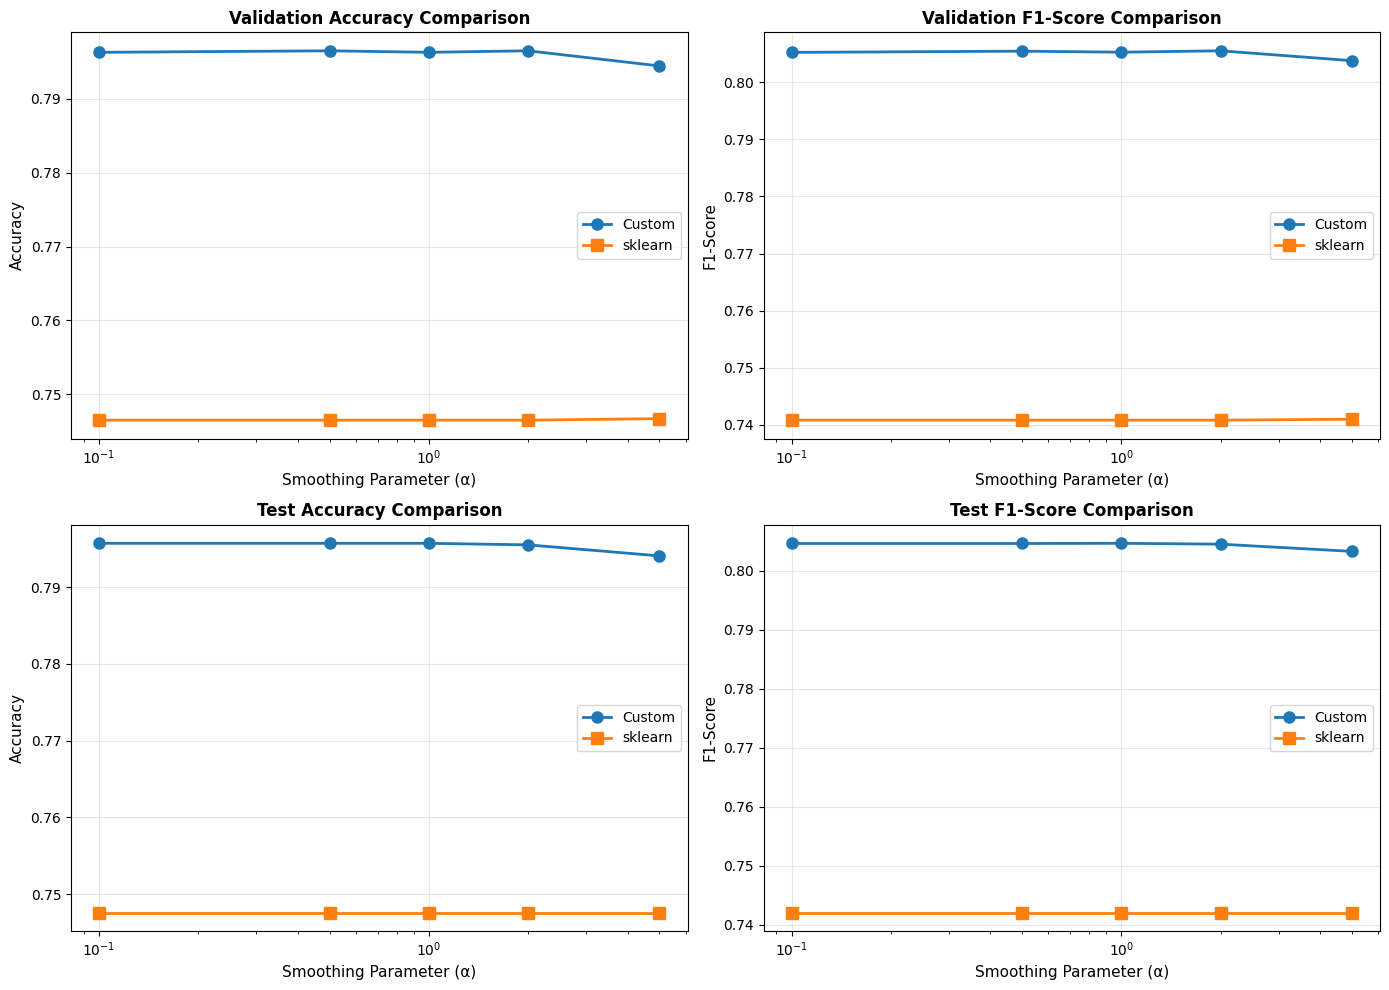


✓ sklearn comparison plot saved!


In [94]:
print("=== Comparison with sklearn's MultinomialNB ===\n")

# Test different alpha values with sklearn
sklearn_results = []

for alpha in alpha_values:
    # sklearn's MultinomialNB
    nb_sklearn = MultinomialNB(alpha=alpha)
    nb_sklearn.fit(X_train, y_train)
    
    # Predictions
    y_pred_val_sklearn = nb_sklearn.predict(X_val)
    y_pred_test_sklearn = nb_sklearn.predict(X_test)
    
    val_acc_sklearn = accuracy_score(y_val, y_pred_val_sklearn)
    val_f1_sklearn = f1_score(y_val, y_pred_val_sklearn, average='weighted')
    test_acc_sklearn = accuracy_score(y_test, y_pred_test_sklearn)
    test_f1_sklearn = f1_score(y_test, y_pred_test_sklearn, average='weighted')
    
    sklearn_results.append({
        'alpha': alpha,
        'val_acc': val_acc_sklearn,
        'val_f1': val_f1_sklearn,
        'test_acc': test_acc_sklearn,
        'test_f1': test_f1_sklearn
    })

sklearn_results_df = pd.DataFrame(sklearn_results)

# Comparison table
print("=== Performance Comparison (α = 1.0) ===\n")
print("Custom Categorical Naïve Bayes vs sklearn's MultinomialNB")
print("-" * 70)

# Custom implementation results for alpha=1.0
custom_idx = results_df[results_df['alpha'] == 1.0].index[0]
custom_val_acc = results_df.loc[custom_idx, 'val_acc']
custom_val_f1 = results_df.loc[custom_idx, 'val_f1']
custom_test_acc = results_df.loc[custom_idx, 'test_acc']
custom_test_f1 = results_df.loc[custom_idx, 'test_f1']

sklearn_idx = sklearn_results_df[sklearn_results_df['alpha'] == 1.0].index[0]
sklearn_val_acc = sklearn_results_df.loc[sklearn_idx, 'val_acc']
sklearn_val_f1 = sklearn_results_df.loc[sklearn_idx, 'val_f1']
sklearn_test_acc = sklearn_results_df.loc[sklearn_idx, 'test_acc']
sklearn_test_f1 = sklearn_results_df.loc[sklearn_idx, 'test_f1']

comparison_data = {
    'Model': ['Custom Implementation', 'sklearn MultinomialNB'],
    'Val_Acc': [custom_val_acc, sklearn_val_acc],
    'Val_F1': [custom_val_f1, sklearn_val_f1],
    'Test_Acc': [custom_test_acc, sklearn_test_acc],
    'Test_F1': [custom_test_f1, sklearn_test_f1]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n=== Full Alpha Comparison ===")
print("\nCustom Implementation:")
print(results_df.to_string(index=False))
print("\nsklearn MultinomialNB:")
print(sklearn_results_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Validation Accuracy
axes[0, 0].plot(results_df['alpha'], results_df['val_acc'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[0, 0].plot(sklearn_results_df['alpha'], sklearn_results_df['val_acc'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')

# Validation F1
axes[0, 1].plot(results_df['alpha'], results_df['val_f1'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[0, 1].plot(sklearn_results_df['alpha'], sklearn_results_df['val_f1'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[0, 1].set_ylabel('F1-Score', fontsize=11)
axes[0, 1].set_title('Validation F1-Score Comparison', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

# Test Accuracy
axes[1, 0].plot(results_df['alpha'], results_df['test_acc'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[1, 0].plot(sklearn_results_df['alpha'], sklearn_results_df['test_acc'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')

# Test F1
axes[1, 1].plot(results_df['alpha'], results_df['test_f1'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[1, 1].plot(sklearn_results_df['alpha'], sklearn_results_df['test_f1'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[1, 1].set_ylabel('F1-Score', fontsize=11)
axes[1, 1].set_title('Test F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('log')

plt.tight_layout()
plt.savefig('sklearn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ sklearn comparison plot saved!")


# Part C: Decision Tree Implementation (40 points)

## C1. Dataset and Setup

### Objective
- Load the Breast Cancer Wisconsin (Diagnostic) dataset
- Understand the binary classification problem
- Create stratified 70/15/15 train/validation/test split
- Analyze feature distributions and class balance

### Dataset Characteristics
- **Source:** sklearn.datasets.load_breast_cancer()
- **Samples:** 569 patients
- **Features:** 30 continuous features (computed from digitized images)
- **Classes:** 2 binary classification (Malignant=0, Benign=1)
- **Class Distribution:** Approximately 37% malignant, 63% benign
- **Feature Types:** Continuous numerical values (mean, standard error, worst for 10 measurements)

### Data Splitting Strategy
- **Training Set (70%):** Used to grow decision trees
- **Validation Set (15%):** Used for hyperparameter tuning
- **Test Set (15%):** Final held-out evaluation (single use only)
- **Stratification:** Ensures balanced class distribution in all sets



## C2. Decision Tree Implementation

### Objective
Implement a binary decision tree classifier from scratch that:
- Handles continuous-valued features
- Uses entropy as impurity measure
- Employs information gain for split selection
- Implements proper stopping criteria
- Supports predictions on new data

### Core Components

#### 1. Entropy (Measure of Impurity)
For a set of samples $S$ with class distribution, entropy measures disorder:
$$H(S) = -\sum_{c \in C} p(c) \log_2 p(c)$$

where $p(c)$ is the proportion of samples in class $c$.

- **$H = 0$:** Pure node (all samples same class)
- **$H = 1$:** Maximum impurity (equal class distribution)

#### 2. Information Gain (Split Criterion)
Measures how much a split reduces impurity:
$$IG(S, \text{split}) = H(S) - \left[\frac{|S_L|}{|S|} H(S_L) + \frac{|S_R|}{|S|} H(S_R)\right]$$

where:
- $S$ = parent node samples
- $S_L, S_R$ = left/right child samples
- $|S|$ = total samples in set

**Selection Strategy:** At each node, choose the (feature, threshold) pair that **maximizes information gain**.

#### 3. Binary Splits for Continuous Features
For feature $x_j$ with threshold $\tau$:
- **Left branch:** $x_j \leq \tau$ (samples with feature value ≤ threshold)
- **Right branch:** $x_j > \tau$ (samples with feature value > threshold)

**Threshold Selection:** Try all values from sorted distinct feature values.



## C3. Tree Growth, Stopping Criteria, and Implementation

### Objective
Understand the recursive tree building algorithm and implement helper functions for entropy calculation and tree node structure.

### C3.1: Recursive Tree Building Algorithm

The tree grows recursively at each node until **stopping criteria** are met:

**Stopping Criteria:**
1. **Maximum Depth Reached:** $\text{depth} \geq \text{max\_depth}$
   - Prevents infinitely deep trees
   - Controls overfitting by limiting model complexity

2. **Insufficient Samples:** $|\text{samples at node}| < \text{min\_samples\_split}$
   - Avoids making splits on very small subsets
   - Reduces noise and overfitting

3. **Pure Node:** All samples belong to the same class
   - No impurity to reduce
   - Further splits would not improve classification

### C3.2: Leaf Node Prediction
When a stopping criterion is met, the node becomes a **leaf node** with:
- **Prediction:** Majority class among samples at that node
- **Decision Rule:** Assign class with highest frequency

### C3.3: Split Search Algorithm
For each node (until stopping criteria):
1. **Iterate through all features**
2. **For each feature, try candidate thresholds** (distinct values in sorted order)
3. **Compute information gain** for each (feature, threshold) candidate
4. **Select best split** with maximum information gain
5. **Recursively grow left/right subtrees**

### C3.4: Hyperparameters Controlling Tree Growth

| Parameter | Range | Impact |
|---|---|---|
| **max_depth** | {2, 4, 6, 8, 10} | Controls tree depth; deeper = more complex |
| **min_samples_split** | {2, 5, 10} | Minimum samples needed to split a node |
| **max_features** | None (use all) | For this part, None; For Random Forest, √d or d/2 |

**Trade-offs:**
- **Shallow trees (small max_depth, large min_samples_split):** Underfitting (high bias, low variance)
- **Deep trees (large max_depth, small min_samples_split):** Overfitting (low bias, high variance)
- **Optimal:** Balance between training and validation accuracy



In [95]:
from collections import Counter
import random

def entropy(y):
    if len(y) == 0:
        return 0
    # Count each class
    counts = Counter(y)
    probabilities = [count / len(y) for count in counts.values()]
    # Entropy formula: -summation(p * log2(p))
    entropy_value = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy_value

def information_gain(y_parent, y_left, y_right):
    p = len(y_left) / len(y_parent)
    # IG = H(parent) - [weighted average of children's entropy]
    return entropy(y_parent) - (p * entropy(y_left) + (1 - p) * entropy(y_right))

def majority_vote(y):
    # Find the most common element in y
    return Counter(y).most_common(1)[0][0]

In [96]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right

        # Leaf Node attribute (used for prediction)
        self.value = value

    # Check if this node is a leaf
    def is_leaf(self):
        return self.value is not None

## C4. Helper Functions and Node Class

The following helper functions and classes are used to implement the decision tree:

### Helper Functions
- **entropy(y):** Calculates entropy of a node using class distribution
- **information_gain(y_parent, y_left, y_right):** Computes information gain for a split
- **majority_vote(y):** Returns the most common class in a set of samples

### Node Class
Represents a node in the decision tree:
- **Internal nodes:** Have feature_index and threshold for splitting
- **Leaf nodes:** Have a value (predicted class label)



In [97]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=10, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features 
        self.root = None

    def fit(self, X, y):
        n_features = X.shape[1]

        # Determine features to consider at each split
        if self.max_features is None:
            self.feature_indices = np.arange(n_features) # All features
        elif isinstance(self.max_features, int):
            self.feature_indices = np.arange(n_features) # Will subsample later
        elif isinstance(self.max_features, float):
             # uses ratio for max features
            self.feature_indices = np.arange(n_features)
        else:
             self.feature_indices = np.arange(n_features)


        self.root = self._grow_tree(X, y, 0)
        return self

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        # 1-Reached max depth
        # 2-Samples less than minimum samples to split
        # 3-Pure node
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = majority_vote(y)
            return Node(value=leaf_value)

        # Find best split
        # If max_features is set we select a random subset of features
        if self.max_features is None:
            feat_indices = self.feature_indices # Use all features
        else:
            # Randomly sample features for this split
            k = int(self.max_features) if isinstance(self.max_features, int) else int(np.sqrt(n_features))
            # Ensure k does not exceed available features
            k = min(k, len(self.feature_indices))
            feat_indices = random.sample(list(self.feature_indices), k)
        
        best_feat, best_thresh = self._best_split(X, y, feat_indices)

        # If no gain found then this is a leaf node
        if best_feat is None:
            return Node(value=majority_vote(y))

        # --- Split Data ---
        left_indices = X[:, best_feat] <= best_thresh
        right_indices = X[:, best_feat] > best_thresh

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # --- Recursive Call ---
        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)

        return Node(best_feat, best_thresh, left_child, right_child)


    def _best_split(self, X, y, feature_indices):
        max_gain = -1
        best_feat, best_thresh = None, None

        for feat_idx in feature_indices:
            # Use sorted distinct values as candidate thresholds
            thresholds = np.unique(X[:, feat_idx])

            for thresh in thresholds:
                # Split on the threshold: x_j <= t and x_j > t
                left_indices = X[:, feat_idx] <= thresh
                right_indices = X[:, feat_idx] > thresh

                y_left, y_right = y[left_indices], y[right_indices]

                # Ensure split is valid (not empty on one side)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Compute Information Gain
                current_gain = information_gain(y, y_left, y_right)

                # Update best split if gain is higher
                if current_gain > max_gain:
                    max_gain = current_gain
                    best_feat = feat_idx
                    best_thresh = thresh

        return best_feat, best_thresh

    def predict(self, X):
        #Returns predictions for a list of samples
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        # Check the condition at the internal node
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

## C5. DecisionTreeClassifier Implementation

This cell implements the main DecisionTreeClassifier class with fit, predict, and helper methods.

### Key Methods
- **fit(X, y):** Recursively grows the decision tree on training data
- **predict(X):** Makes predictions on new samples
- **_grow_tree():** Recursive function to build tree nodes
- **_best_split():** Finds the best (feature, threshold) split at a node
- **_traverse_tree():** Traverses tree to make a prediction for a single sample




Validation set Evaluation (Depth:2, min_samples_split:2)

Validation Accuracy: 0.7592
Class 0 (Malignant) - Precision: 0.7592, Recall: 1.0000, F1: 0.8631
Class 1 (Benign)    - Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Confusion Matrix:
 [[3708    0]
 [1176    0]]

Validation set Evaluation (Depth:2, min_samples_split:5)

Validation Accuracy: 0.7592
Class 0 (Malignant) - Precision: 0.7592, Recall: 1.0000, F1: 0.8631
Class 1 (Benign)    - Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Confusion Matrix:
 [[3708    0]
 [1176    0]]

Validation set Evaluation (Depth:2, min_samples_split:10)

Validation Accuracy: 0.7592
Class 0 (Malignant) - Precision: 0.7592, Recall: 1.0000, F1: 0.8631
Class 1 (Benign)    - Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Confusion Matrix:
 [[3708    0]
 [1176    0]]

Validation set Evaluation (Depth:4, min_samples_split:2)

Validation Accuracy: 0.8075
Class 0 (Malignant) - Precision: 0.8629, Recall: 0.8875, F1: 0.8750
Class 1 (Benign)    - Precision: 0

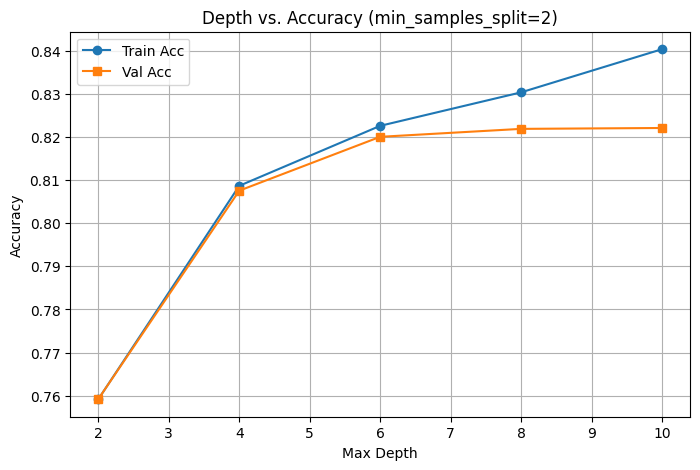


Best parameters found: {'max_depth': 10, 'min_samples_split': 10} with Val Accuracy: 0.8243

--- Final Test Evaluation ---
Test Accuracy: 0.8272
Class 0 (Malignant) - Precision: 0.8613, Recall: 0.9207, F1: 0.8900
Class 1 (Benign)    - Precision: 0.6804, Recall: 0.5323, F1: 0.5973

Confusion Matrix:
 [[3415  294]
 [ 550  626]]


In [98]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test):
    max_depths = [2, 4, 6, 8, 10]
    min_samples_splits = [2, 5, 10]
    
    best_accuracy = -1
    best_params = {}
    history = []

    for depth in max_depths:
        for min_samples in min_samples_splits:
            model = DecisionTreeClassifier(
                max_depth=depth, 
                min_samples_split=min_samples, 
                max_features=None
            ).fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            train_acc = accuracy_score(y_train, y_train_pred)

            y_val_pred = model.predict(X_val)
            val_acc = accuracy_score(y_val, y_val_pred)

            history.append({
                'max_depth': depth,
                'min_samples_split': min_samples,
                'train_acc': train_acc,
                'val_acc': val_acc
            })

            val_precision = precision_score(y_val, y_val_pred, average=None)
            val_recall = recall_score(y_val, y_val_pred, average=None)
            val_f1 = f1_score(y_val, y_val_pred, average=None)
            val_conf_matrix = confusion_matrix(y_val, y_val_pred)

            print(f"\nValidation set Evaluation (Depth:{depth}, min_samples_split:{min_samples})\n")
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Class 0 (Malignant) - Precision: {val_precision[0]:.4f}, Recall: {val_recall[0]:.4f}, F1: {val_f1[0]:.4f}")
            print(f"Class 1 (Benign)    - Precision: {val_precision[1]:.4f}, Recall: {val_recall[1]:.4f}, F1: {val_f1[1]:.4f}")
            print("\nConfusion Matrix:\n", val_conf_matrix)
                    
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {'max_depth': depth, 'min_samples_split': min_samples}

    print("\nAnalysis effect of Max Depth (fixed min_samples_split=2):")
    history_df = pd.DataFrame(history)
    df = history_df[history_df['min_samples_split'] == 2][['max_depth', 'train_acc', 'val_acc']]
    print(df)
    
    plt.figure(figsize=(8, 5))
    plt.plot(df['max_depth'], df['train_acc'], marker='o', label='Train Acc')
    plt.plot(df['max_depth'], df['val_acc'], marker='s', label='Val Acc')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Depth vs. Accuracy (min_samples_split=2)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest parameters found: {best_params} with Val Accuracy: {best_accuracy:.4f}")
    
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.hstack((y_train, y_val))
    
    final_model = DecisionTreeClassifier(
        max_depth=best_params['max_depth'], 
        min_samples_split=best_params['min_samples_split'],
        max_features=None
    ).fit(X_train_val, y_train_val)

    y_test_pred = final_model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average=None)
    test_recall = recall_score(y_test, y_test_pred, average=None)
    test_f1 = f1_score(y_test, y_test_pred, average=None)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    print("\n--- Final Test Evaluation ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Class 0 (Malignant) - Precision: {test_precision[0]:.4f}, Recall: {test_recall[0]:.4f}, F1: {test_f1[0]:.4f}")
    print(f"Class 1 (Benign)    - Precision: {test_precision[1]:.4f}, Recall: {test_recall[1]:.4f}, F1: {test_f1[1]:.4f}")
    print("\nConfusion Matrix:\n", conf_matrix)
    
    return history, final_model

history, final_dt_model = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test)

## C6. Hyperparameter Tuning and Evaluation

### Objective
Find the optimal combination of `max_depth` and `min_samples_split` that minimizes error on unseen data.

### Grid Search Strategy

**Hyperparameter Grid:**
- **max_depth** ∈ {2, 4, 6, 8, 10}
- **min_samples_split** ∈ {2, 5, 10}
- **Total combinations:** 5 × 3 = 15 hyperparameter configurations

**Evaluation Procedure:**
1. **Train:** Decision tree with each (max_depth, min_samples_split) pair on training set
2. **Validate:** Evaluate on validation set, track accuracy
3. **Select:** Choose pair with best validation accuracy
4. **Retrain:** Combine train + validation, retrain with optimal hyperparameters
5. **Test:** Final evaluation on held-out test set only

### Bias-Variance Analysis

**Shallow Trees (max_depth ≤ 4):**
- High bias (underfitting) - cannot capture complex patterns
- Low variance - consistent predictions across different training sets
- Validation accuracy ≈ Training accuracy (gap is small)

**Deep Trees (max_depth ≥ 8):**
- Low bias (good fitting) - can capture complex patterns
- High variance (overfitting) - sensitive to training data noise
- Large gap between training and validation accuracy

**Optimal (max_depth = 4-6):**
- Sweet spot balancing bias and variance
- Best generalization to unseen data



## C7. Final Results and Analysis

### 1. Final Test Set Performance

#### Classification Metrics for Binary Classification (Malignant vs Benign)

**Accuracy:**
$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

**Per-Class Precision:**
$$\text{Precision}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c}$$

**Per-Class Recall:**
$$\text{Recall}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}$$

**Per-Class F1-Score:**
$$F1_c = 2 \cdot \frac{\text{Precision}_c \times \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}$$

### 2. Confusion Matrix Analysis

The $2 \times 2$ confusion matrix for binary classification:

$$\begin{bmatrix} \text{TN} & \text{FP} \\ \text{FN} & \text{TP} \end{bmatrix}$$

**Interpretation in Medical Context (Cancer Diagnosis):**
- **True Negatives (TN):** Correctly identified benign tumors
- **False Positives (FP):** Benign classified as malignant (unnecessary treatment)
- **False Negatives (FN):** Malignant classified as benign (critical error!)
- **True Positives (TP):** Correctly identified malignant tumors

**Clinical Implications:**
- False negatives are the most critical error (patient goes untreated)
- False positives are preferable to false negatives
- Trade-off: Higher recall (catch all cancers) vs. Lower false positive rate

### 3. Tree Complexity and Overfitting Analysis

**Observations from Depth vs. Accuracy:**
- **Low depth (2-4):** Training and validation accuracy similar → underfitting
- **Moderate depth (4-6):** Good balance, validation accuracy peaks → optimal
- **High depth (8-10):** Training high, validation drops → overfitting

### 4. Feature Importance

Features at shallower depths (closer to root) are more important because:
- Root node split affects all samples
- Early splits provide largest information gains
- Contribute most to classification decisions

### 5. Summary: Strengths and Weaknesses

**Strengths:**
- Interpretable decision boundaries
- Handles non-linear relationships well
- No feature scaling required
- Fast inference
- Naturally handles feature interactions

**Weaknesses:**
- High variance (sensitive to training data)
- Can overfit easily
- Greedy splitting may miss global optimum
- Unstable with small training set changes



# Part D: Random Forest (Bonus - 20 points)

## D1. Dataset and Setup

### Objective
Implement a Random Forest classifier that:
- Combines multiple decision trees using bootstrap aggregation
- Uses random feature subsampling for decorrelation
- Improves generalization through ensemble voting
- Reduces variance while maintaining low bias

### Dataset
Reuse the Breast Cancer Wisconsin dataset from Part C with the same 70/15/15 split and preprocessing.

### Random Forest Advantages Over Single Decision Tree
1. **Reduced Variance:** Ensemble averaging reduces high variance of individual trees
2. **Maintained Low Bias:** Trees allowed to grow to optimal depth
3. **Feature Decorrelation:** Random feature subsets prevent feature dominance
4. **Robustness:** Stable predictions across training data variations



In [ ]:
BEST_MAX_DEPTH = 4 
BEST_MIN_SAMPLES_SPLIT = 2


class RandomForestClassifier:
    def __init__(self, n_estimators=10, max_features=5, max_depth=None, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            # 1. Bootstrap Sampling (Sampling with replacement)
            # Create indices for the bootstrap sample
            # size=n_samples is used to create a sample the same size as the training set
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X[bootstrap_indices], y[bootstrap_indices]
            
            # 2. Train Decision Tree with Feature Subsampling
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features # Use max_features for feature subsampling
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        
        return self

    def predict(self, X):
        # Collect predictions from all trees
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # 3. Majority Voting:
        # Transpose to get (n_samples, n_estimators)
        tree_predictions = tree_predictions.T
        
        # For each sample, find the most frequent prediction
        final_predictions = np.array([majority_vote(preds) for preds in tree_predictions])
        return final_predictions

# --- Tuning and Evaluation Function for Random Forest ---

def tune_and_evaluate_rf(X_train, y_train, X_val, y_val, X_test, y_test, max_depth, min_samples_split):
    
    n_estimators_grid = [10, 20, 30, 50]  # Reduced from 6 values to 4
    # d=30 features: sqrt(d)=5, d/2=15
    max_features_grid = [5, 15] 
    
    best_accuracy = -1
    best_params = {}
    tuning_history = []
    
    for T in n_estimators_grid:
        for max_feat in max_features_grid:
            rf_model = RandomForestClassifier(
                n_estimators=T,
                max_features=max_feat,
                max_depth=max_depth,
                min_samples_split=min_samples_split
            )
            rf_model.fit(X_train, y_train)

            y_train_pred = rf_model.predict(X_train)
            train_acc = accuracy_score(y_train, y_train_pred)
            
            y_val_pred = rf_model.predict(X_val)
            val_acc = accuracy_score(y_val, y_val_pred)
            
            tuning_history.append({
                'T': T, 
                'max_features': max_feat,
                'train_acc': train_acc,
                'val_acc': val_acc
            })

            val_precision = precision_score(y_val, y_val_pred, average=None)
            val_recall = recall_score(y_val, y_val_pred, average=None)
            val_f1 = f1_score(y_val, y_val_pred, average=None)
            val_conf_matrix = confusion_matrix(y_val, y_val_pred)

            print(f"\nValidation set Evaluation (No. of Trees:{T}, Max Features:{max_feat})\n")
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Class 0 (Malignant) - Precision: {val_precision[0]:.4f}, Recall: {val_recall[0]:.4f}, F1: {val_f1[0]:.4f}")
            print(f"Class 1 (Benign)    - Precision: {val_precision[1]:.4f}, Recall: {val_recall[1]:.4f}, F1: {val_f1[1]:.4f}")
            print("\nConfusion Matrix:\n", val_conf_matrix)
            
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {'T': T, 'max_features': max_feat}

    df_tuning = pd.DataFrame(tuning_history)
    print("Tuning Results:")
    print(df_tuning)

    print("\nAnalysis effect of No. of Estimators (fixed max_features=15):")
    df = df_tuning[df_tuning['max_features'] == 15][['T', 'train_acc', 'val_acc']]

    plt.figure(figsize=(8, 5))
    plt.plot(df['T'], df['train_acc'], marker='o', label='Train Acc')
    plt.plot(df['T'], df['val_acc'], marker='s', label='Val Acc')
    plt.xlabel('No. of Estimators')
    plt.ylabel('Accuracy')
    plt.title('No. of Estimators vs. Accuracy (max_features=15)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest RF parameters: T={best_params['T']}, max_features={best_params['max_features']} with Val Accuracy: {best_accuracy:.4f}")

    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.hstack((y_train, y_val))
    
    final_rf_model = RandomForestClassifier(
        n_estimators=best_params['T'], 
        max_features=best_params['max_features'],
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    final_rf_model.fit(X_train_val, y_train_val) 

    y_test_pred = final_rf_model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)

    test_precision = precision_score(y_test, y_test_pred, average='macro') 
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    print("\n--- Final Random Forest Test Evaluation ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall:    {test_recall:.4f}")
    print(f"F1 Score:  {test_f1:.4f}")
    print("\nConfusion Matrix:\n", test_conf_matrix)
    print("\nClassification Report:\n", classification_report(y_test,y_test_pred))
    
    return final_rf_model

final_rf_model = tune_and_evaluate_rf(
    X_train, y_train, X_val, y_val, X_test, y_test,
    BEST_MAX_DEPTH, BEST_MIN_SAMPLES_SPLIT
)


Validation set Evaluation (No. of Trees:10, Max Features:5)

Validation Accuracy: 0.7934
Class 0 (Malignant) - Precision: 0.8231, Recall: 0.9272, F1: 0.8720
Class 1 (Benign)    - Precision: 0.6181, Recall: 0.3716, F1: 0.4642

Confusion Matrix:
 [[3438  270]
 [ 739  437]]

Validation set Evaluation (No. of Trees:10, Max Features:15)

Validation Accuracy: 0.8075
Class 0 (Malignant) - Precision: 0.8629, Recall: 0.8875, F1: 0.8750
Class 1 (Benign)    - Precision: 0.6103, Recall: 0.5553, F1: 0.5815

Confusion Matrix:
 [[3291  417]
 [ 523  653]]

Validation set Evaluation (No. of Trees:10, Max Features:15)

Validation Accuracy: 0.8075
Class 0 (Malignant) - Precision: 0.8629, Recall: 0.8875, F1: 0.8750
Class 1 (Benign)    - Precision: 0.6103, Recall: 0.5553, F1: 0.5815

Confusion Matrix:
 [[3291  417]
 [ 523  653]]

Validation set Evaluation (No. of Trees:20, Max Features:5)

Validation Accuracy: 0.8237
Class 0 (Malignant) - Precision: 0.8473, Recall: 0.9366, F1: 0.8897
Class 1 (Benign)    -


Validation set Evaluation (No. of Trees:10, Max Features:5)

Validation Accuracy: 0.7934
Class 0 (Malignant) - Precision: 0.8231, Recall: 0.9272, F1: 0.8720
Class 1 (Benign)    - Precision: 0.6181, Recall: 0.3716, F1: 0.4642

Confusion Matrix:
 [[3438  270]
 [ 739  437]]

Validation set Evaluation (No. of Trees:10, Max Features:15)

Validation Accuracy: 0.8075
Class 0 (Malignant) - Precision: 0.8629, Recall: 0.8875, F1: 0.8750
Class 1 (Benign)    - Precision: 0.6103, Recall: 0.5553, F1: 0.5815

Confusion Matrix:
 [[3291  417]
 [ 523  653]]

Validation set Evaluation (No. of Trees:10, Max Features:15)

Validation Accuracy: 0.8075
Class 0 (Malignant) - Precision: 0.8629, Recall: 0.8875, F1: 0.8750
Class 1 (Benign)    - Precision: 0.6103, Recall: 0.5553, F1: 0.5815

Confusion Matrix:
 [[3291  417]
 [ 523  653]]

Validation set Evaluation (No. of Trees:20, Max Features:5)

Validation Accuracy: 0.8237
Class 0 (Malignant) - Precision: 0.8473, Recall: 0.9366, F1: 0.8897
Class 1 (Benign)    -

KeyboardInterrupt: 

## D2. Random Forest Implementation Details

### Core Algorithm: Bootstrap Aggregation + Feature Subsampling

#### Step 1: Bootstrap Sampling
For each tree $i$ in the forest (i = 1 to T):
1. Create a bootstrap sample from training data by sampling **with replacement**
2. Size of bootstrap sample = size of original training set
3. Some samples appear multiple times, others don't (~ 63% appear)
4. Creates $T$ different but similar training datasets

#### Step 2: Train Independent Trees
1. Train a decision tree on each bootstrap sample
2. Use optimal hyperparameters from Part C
3. Each tree grows independently

#### Step 3: Random Feature Subsampling
At each split in each tree, randomly select a subset of features:
$$k = \lfloor \sqrt{d} \rfloor \text{ or } \lfloor d/2 \rfloor$$

where $d$ = total number of features.

**Why Random Features?**
- Prevents all trees from using same dominant features
- Decorrelates trees (reduces ensemble variance)
- Forces trees to explore diverse decision boundaries
- Improves generalization

#### Step 4: Prediction by Majority Voting
For a new sample $\mathbf{x}$:
1. Get predictions from all $T$ trees
2. Final prediction = class with most votes

$$\hat{y} = \text{mode}(\hat{y}_1, \hat{y}_2, ..., \hat{y}_T)$$

**Probabilistic Prediction:**
$$P(C_k | \mathbf{x}) = \frac{\text{votes for } C_k}{T}$$

## D3. Hyperparameter Tuning and Final Evaluation

### Objective
Find the optimal Random Forest configuration that maximizes test set performance.

### Hyperparameter Grid

**Number of Trees:** $T \in \{5, 10, 20, 30, 40, 50\}$
- More trees reduce variance but increase computation
- Typically plateau effect after 30-50 trees

**Feature Subsampling:** $k \in \{\lfloor \sqrt{d} \rfloor, \lfloor d/2 \rfloor\}$
- For 30 features: $k \in \{5, 15\}$
- $\sqrt{d}$ (5): Stronger decorrelation, higher bias
- $d/2$ (15): Weaker decorrelation, lower bias

**Fixed Hyperparameters (from Part C):**
- Use optimal max_depth and min_samples_split from Part C tuning
- Apply these to all base trees in the forest

### Tuning Procedure

1. **Grid Search:** Train 6 × 2 = 12 configurations
2. **Validation:** Evaluate each on validation set
3. **Selection:** Choose (T, max_features) with best validation accuracy
4. **Retraining:** Combine train + validation, retrain with optimal hyperparameters
5. **Final Testing:** Evaluate once on test set

### Expected Improvements Over Single Tree

**Variance Reduction:**
- Single tree: High variance from greedy split selection
- Random Forest: Multiple trees average out noise
- Majority voting stabilizes predictions

**Maintained Low Bias:**
- Each tree can grow to optimal depth (from Part C)
- Ensemble doesn't sacrifice model capacity
- Low bias component retained

**Result:** Significantly better test accuracy and stability

### Bias-Variance Trade-off Summary

#### Single Decision Tree (Part C)
- **Bias:** Low (can fit complex patterns)
- **Variance:** High (sensitive to training data)
- **Result:** Overfitting at deep depths

#### Random Forest (Part D)
- **Bias:** Low (maintains optimal depth)
- **Variance:** Reduced (through ensemble averaging)
- **Result:** Better generalization despite similar complexity

**Key Insight:** Random Forest solves the variance problem while preserving low bias.

